## Notebook for semantic segmentation of land cover
- Use (12.5cm currently) aerial images (3 bands)
- Use raster masks with class labels
- Use U-net (like) CNN to perform semantic segmentation. 

Thoughts:
- Handle no-class? (class = 0). Could fix in data by interpolating - although that takes some time.. Can we somehow set the cost to 0 of these pixels? Don't want to ruin the conv filters. 
- Possibly change class labels here. (Eg wood vs grass vs other). Probably best to do here when loading raster masks, instead of creating masks like this directly (as they take up considerable disk space and there might be many version. Should be quick to do.)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import torch
import torchvision

ImportError: cannot import name 'PILLOW_VERSION' from 'PIL' (/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/PIL/__init__.py)

### Split image into patches:

In [3]:
all_patches_img, all_patches_mask = lca.create_all_patches_from_dir(patch_size=500)

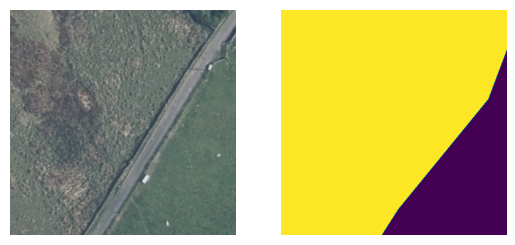

In [4]:
fig, ax = plt.subplots(1, 2)
i_p = 0  # index of patch. Left to righ, top to bottom 
lcv.plot_image_simple(im=all_patches_img[i_p, :, :, :], ax=ax[0])

ax[1].imshow(all_patches_mask[i_p, :, :])
lcv.naked(ax[1])

### Create train/test split
- Random split for now. 
- Later look into way to split classes evenly across train and test set. 

In [5]:
im_train, im_test, mask_train, mask_test = lca.split_patches_in_train_test(all_patches_img=all_patches_img, all_patches_mask=all_patches_mask)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


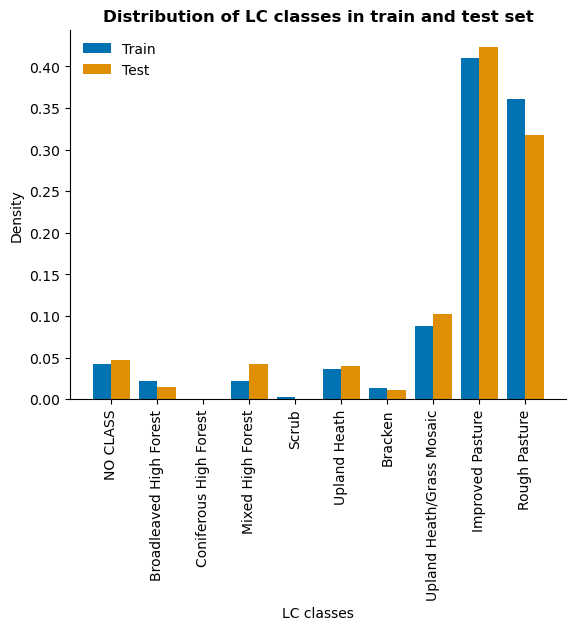

In [6]:
lcv.plot_comparison_class_balance_train_test(train_patches_mask=mask_train, test_patches_mask=mask_test)

### Fetch CNN model:
- Resource 1: UNet (https://github.com/milesial/Pytorch-UNet)
- Resource 2: Pytorch pretrained (only Resnet): https://pytorch.org/vision/stable/models.html and https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- Resource 3: SM pretrained: https://github.com/qubvel/segmentation_models.pytorch


### Prep
- See if GPU works:

In [7]:
assert torch.cuda.is_available()

### Resource 1:

In [10]:
net = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)

Downloading: "https://github.com/milesial/Pytorch-UNet/archive/master.zip" to /home/tplas/.cache/torch/hub/master.zip
Downloading: "https://github.com/milesial/Pytorch-UNet/releases/download/v3.0/unet_carvana_scale0.5_epoch2.pth" to /home/tplas/.cache/torch/checkpoints/unet_carvana_scale0.5_epoch2.pth


AttributeError: 'NoneType' object has no attribute 'group'